In [1]:
import os
import numpy as np
import pandas as pd
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
rng = np.random.default_rng(0)
az.style.use("arviz-darkgrid")
%matplotlib inline

### 1. Get SP500 data

In [6]:
# !pip install yfinance

In [7]:
import yfinance as yf

In [9]:
# !pip install pandas_datareader

In [10]:
import pandas_datareader.data as web
import datetime

In [11]:
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()

sp500 = web.DataReader(['sp500'], 'fred', start, end)

In [12]:
sp500.shape

(2609, 1)

In [13]:
sp500.tail()

,sp500
DATE,
2022-02-22,4304.76
2022-02-23,4225.50
2022-02-24,4288.70
2022-02-25,4384.65
2022-02-28,4373.94


In [35]:
sp500.head()

,sp500,change
DATE,,
2012-03-01,1374.09,0.006139
2012-03-02,1369.63,-0.003251
2012-03-05,1364.33,-0.003877
2012-03-06,1343.36,-0.015490
2012-03-07,1352.63,0.006877


In [14]:
df = yf.download(["spy"], start, end)
df.shape

[*********************100%***********************]  1 of 1 completed


(5575, 6)

In [15]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-22,431.890015,435.500000,425.859985,429.570007,429.570007,124391800
2022-02-23,432.660004,433.260010,421.350006,421.950012,421.950012,132578000
2022-02-24,411.019989,428.760010,410.640015,428.299988,428.299988,213942900
2022-02-25,429.609985,437.839996,427.859985,437.750000,437.750000,121715600
2022-02-28,432.029999,438.200012,430.700012,436.630005,436.630005,145347600


In [16]:
sp500["change"] = np.log(sp500["sp500"]).diff()

In [17]:
sp500.isna().sum()

sp500      92
change    184
dtype: int64

In [18]:
sp500 = sp500.dropna()

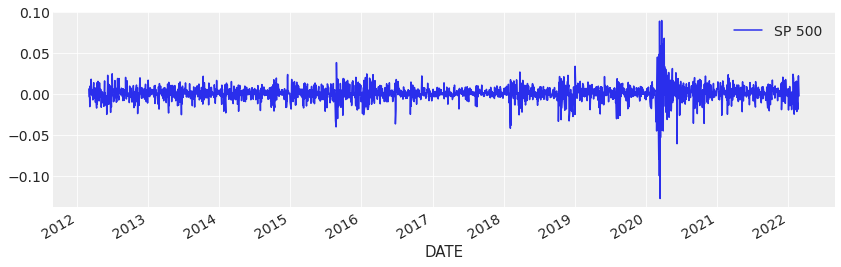

In [19]:
# Plot data
fig, ax = plt.subplots(figsize=(14,4))
sp500.plot(y="change", label="SP 500", ax=ax);

### Model

In [20]:
def make_sv_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, dims="time")
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT("returns", nu=nu, lam=np.exp(-2*volatility), observed=data["change"])
    return model

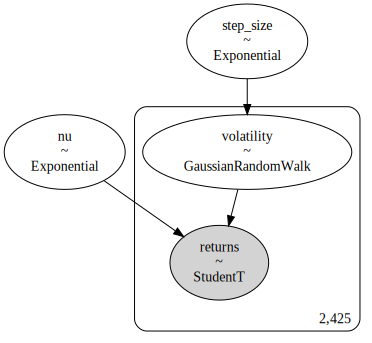

In [21]:
model = make_sv_model(sp500)
pm.model_to_graphviz(model)

In [22]:
with model:
    trace = az.from_pymc3(prior=pm.sample_prior_predictive(1000))

In [23]:
prior_predictive = trace.prior_predictive.stack(pooled_chain=("chain", "draw"))

In [24]:
prior_predictive

<xarray.Dataset>
Dimensions:        (pooled_chain: 1000, returns_dim_0: 2425)
Coordinates:
  * returns_dim_0  (returns_dim_0) int64 0 1 2 3 4 ... 2420 2421 2422 2423 2424
  * pooled_chain   (pooled_chain) MultiIndex
  - chain          (pooled_chain) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  - draw           (pooled_chain) int64 0 1 2 3 4 5 ... 994 995 996 997 998 999
Data variables:
    returns        (returns_dim_0, pooled_chain) float64 -1.945 ... 0.06178
Attributes:
    created_at:                 2022-03-01T05:29:46.675388
    arviz_version:              0.8.3
    inference_library:          pymc3
    inference_library_version:  3.9.0

In [25]:
fig, ax = plt.subplots(figsize=(14, 4))
sp500["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"].isel(pooled_chain=slice(4, 6, None)),
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

NameError: name 'returns' is not defined

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fdd2fc51c20> (for post_execute):


ValueError: view limit minimum -36910.700000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36910.700000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

### Fit Model

In [26]:
with model:
    trace = pm.sample(2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, volatility, step_size]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 175 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [27]:
ppc = trace.posterior.stack(pooled_chain=("chain", "draw"))
ppc["exp_volatility"] = np.exp(ppc["volatility"])

In [28]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

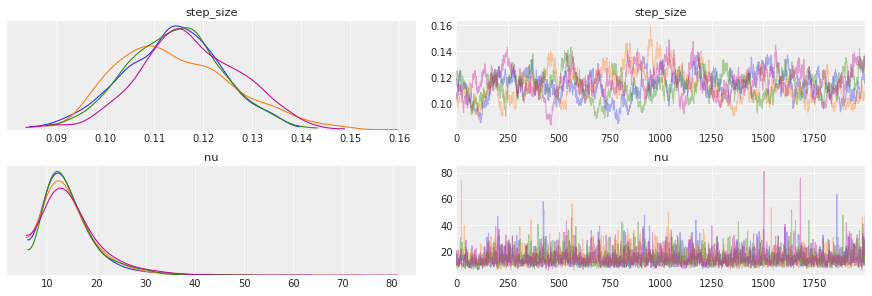

In [29]:
az.plot_trace(trace, var_names=["step_size", "nu"]);

### Posterior predictive check

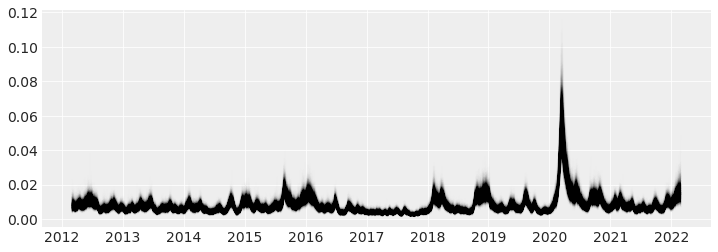

In [31]:
fig, ax = plt.subplots(figsize=(12,4))
y_vals = ppc["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = pd.to_datetime(sp500.index)

plt.plot(x_vals, y_vals, "k", alpha=0.002);

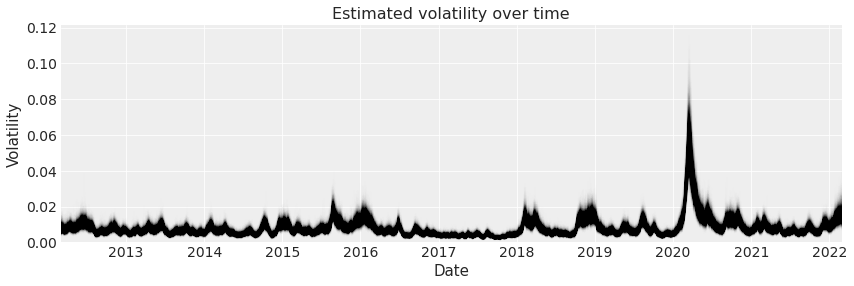

In [32]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = ppc["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = pd.to_datetime(sp500.index)#y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

In [33]:
ppc

<xarray.Dataset>
Dimensions:           (pooled_chain: 8000, volatility_dim_0: 2425)
Coordinates:
  * volatility_dim_0  (volatility_dim_0) int64 0 1 2 3 4 ... 2421 2422 2423 2424
  * pooled_chain      (pooled_chain) MultiIndex
  - chain             (pooled_chain) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw              (pooled_chain) int64 0 1 2 3 4 ... 1996 1997 1998 1999
Data variables:
    volatility        (volatility_dim_0, pooled_chain) float64 -5.437 ... -4.305
    step_size         (pooled_chain) float64 0.1053 0.1066 ... 0.1359 0.1378
    nu                (pooled_chain) float64 17.16 10.32 14.45 ... 21.92 48.09
    exp_volatility    (volatility_dim_0, pooled_chain) float64 0.004351 ... 0.0135
Attributes:
    created_at:                 2022-03-01T05:33:01.333491
    arviz_version:              0.8.3
    inference_library:          pymc3
    inference_library_version:  3.9.0
    sampling_time:              175.11809301376343
    tuning_steps:               2000

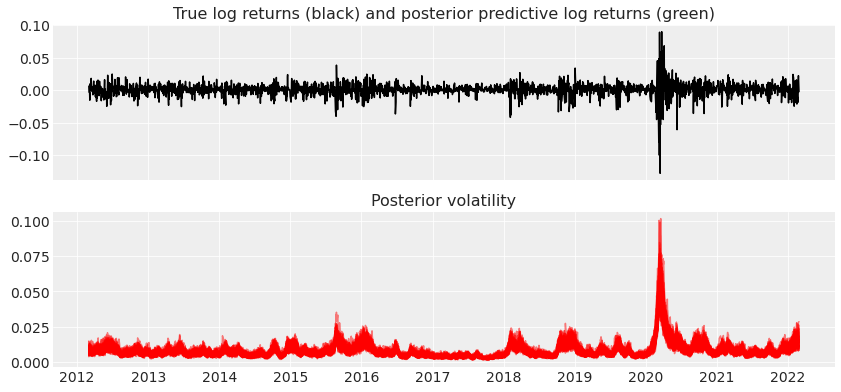

In [34]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
sp500["change"].plot(ax=axes[0], color="black")

axes[1].plot(x_vals, ppc["exp_volatility"].isel(pooled_chain=slice(None, None, 100)), "r", alpha=0.5)
# axes[0].plot(
#     x_vals,
#     ppc["returns"].isel(pooled_chain=slice(None, None, 100)),
#     "g",
#     alpha=0.5,
#     zorder=-10,
# )
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");